## Load data

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

Using Theano backend.


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
datapath = '/media/sf_VBox_Shared/timeseries/EEGs_Guinea-Bissau_np/'#'/media/windows-share/EEGs_Guinea-Bissau_np/'

In [4]:
condition = '_10seconds_closed.npy'
X_train = np.load(datapath+'X_train'+condition)
y_train = np.load(datapath+'y_train'+condition)
X_val = np.load(datapath+'X_valid'+condition)
y_val = np.load(datapath+'y_valid'+condition)
X_test = np.load(datapath+'X_test'+condition)
y_test = np.load(datapath+'y_test'+condition)

In [5]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

{'Control': 0, 'Epilepsy': 1}


In [7]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_test], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

KeyError: 0

In [8]:
y_val_binary

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [9]:
num_classes = y_train_binary.shape[1]
print(num_classes)

2


## Generate models

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [44]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [47]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  max_layers=4,
                                 low_lr=2, high_lr=8)

CPU times: user 1.04 s, sys: 52 ms, total: 1.09 s
Wall time: 1.22 s


In [48]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 6.266192650778009e-06, 'fc_hidden_nodes': 67, 'regularization_rate': 0.000641226389722406, 'filters': array([53, 38, 68])}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_17 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_17[0][0]
____________________________________________________________________________________________________
convolution1d_44 (Convolution1D) (None, 1280, 53)      2279        batchnormalization_17[0][0]      
____________________________________________________________________________________________________
activation_76 (Activation)       (None, 1280, 53)      0           convolution1d_44[0][0]           
____________________________________________________________________________________________________
convolution1d_45 (Convolution1D) (None, 1280, 38)  

## Compare models

In [49]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5,
                                                                                  subsize_set=200,
                                                                                  verbose=True)

Train on 108 samples, validate on 20 samples
Epoch 1/5
108/108 [==============================] - 3s - loss: 0.8298 - acc: 0.5556 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 2/5
108/108 [==============================] - 4s - loss: 0.8059 - acc: 0.6019 - val_loss: 3.3463 - val_acc: 0.5500
Epoch 3/5
108/108 [==============================] - 2s - loss: 0.7608 - acc: 0.6111 - val_loss: 0.9581 - val_acc: 0.5000
Epoch 4/5
108/108 [==============================] - 3s - loss: 0.7260 - acc: 0.6759 - val_loss: 0.8670 - val_acc: 0.5000
Epoch 5/5
108/108 [==============================] - 3s - loss: 0.7470 - acc: 0.6389 - val_loss: 0.8706 - val_acc: 0.5500
Train on 108 samples, validate on 20 samples
Epoch 1/5
108/108 [==============================] - 1s - loss: 1.2406 - acc: 0.5833 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 2/5
108/108 [==============================] - 1s - loss: 1.0477 - acc: 0.5833 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 3/5
108/108 [==============================] - 1s 

CPU times: user 780 ms, sys: 8 ms, total: 788 ms
Wall time: 827 ms


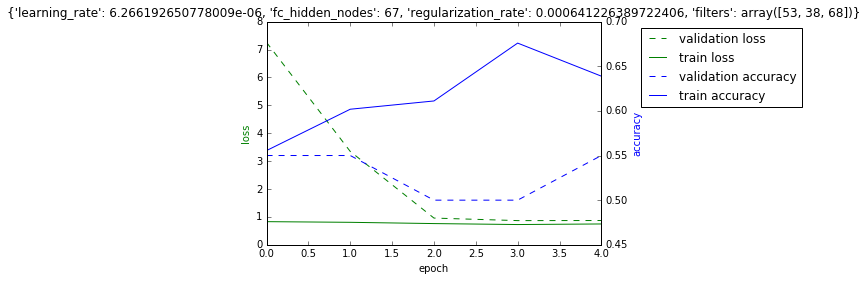

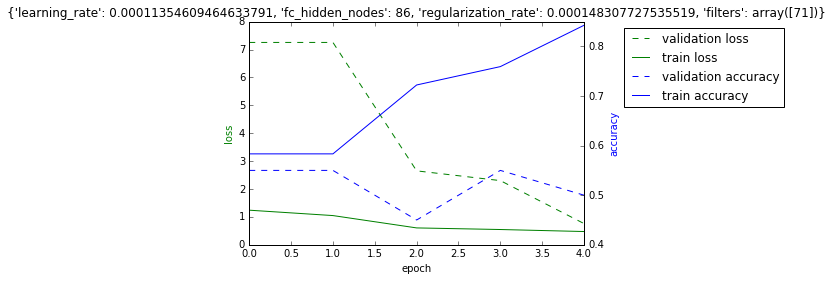

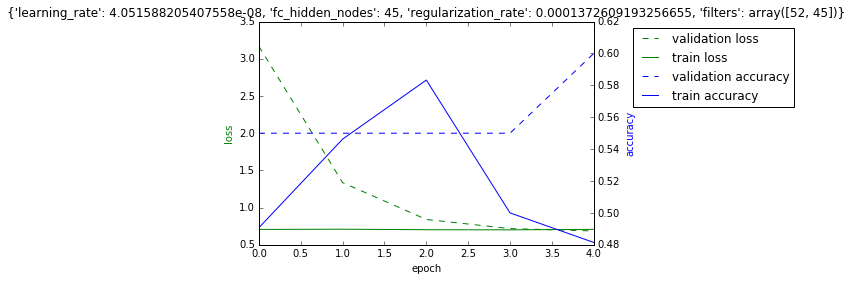

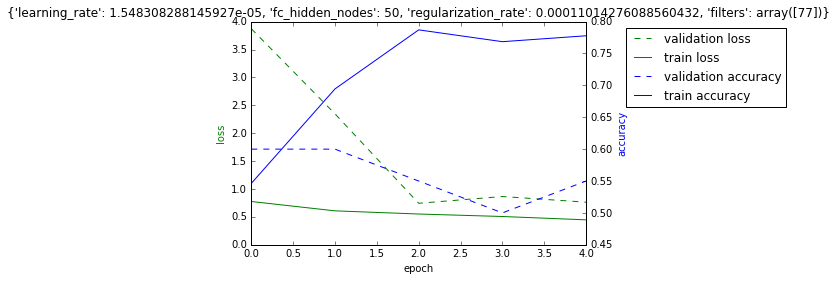

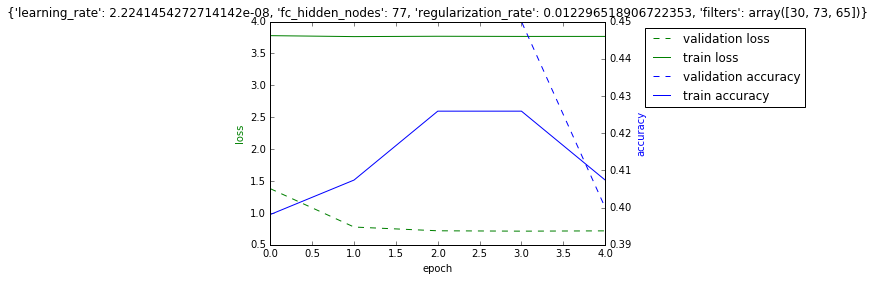

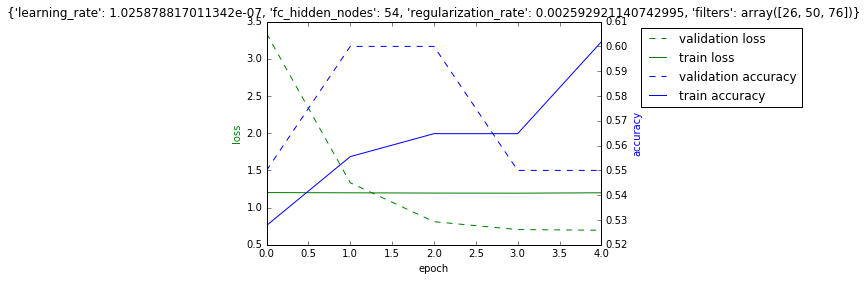

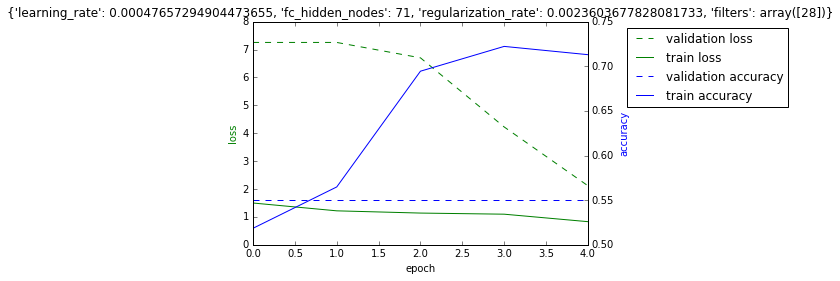

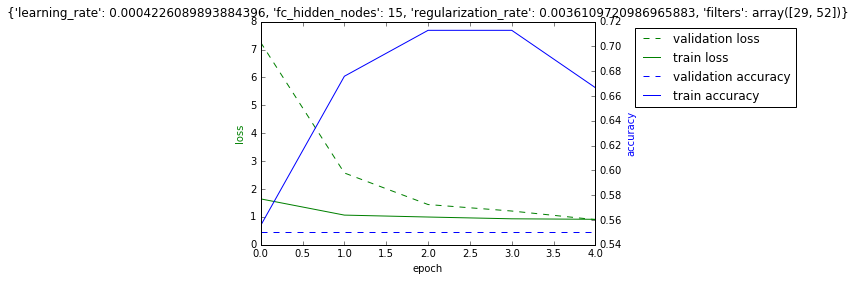

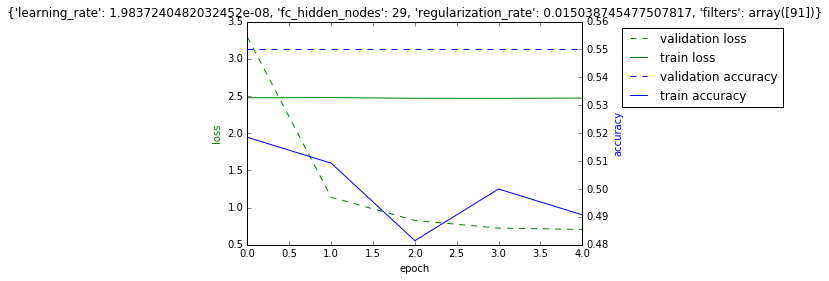

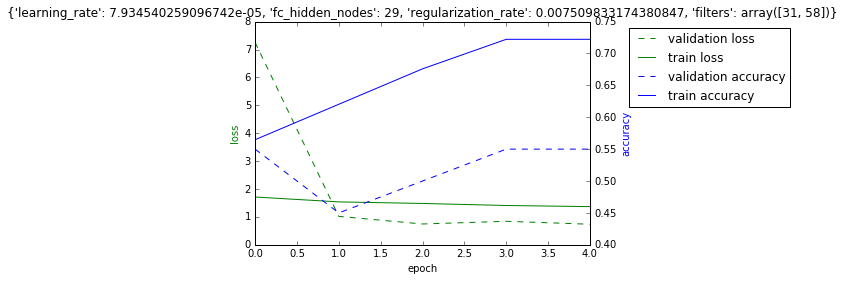

In [50]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [51]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 6.266192650778009e-06, 'fc_h...",0.638889,0.747038,0.55,0.870550
1,"{'learning_rate': 0.00011354609464633791, 'fc_...",0.842593,0.475505,0.50,0.760329
2,"{'learning_rate': 4.051588205407558e-08, 'fc_h...",0.481481,0.707403,0.60,0.686375
3,"{'learning_rate': 1.548308288145927e-05, 'fc_h...",0.777778,0.447353,0.55,0.764025
4,"{'learning_rate': 2.2241454272714142e-08, 'fc_...",0.407407,3.767671,0.40,0.718519
5,"{'learning_rate': 1.025878817011342e-07, 'fc_h...",0.601852,1.199222,0.55,0.695718
6,"{'learning_rate': 0.00047657294904473655, 'fc_...",0.712963,0.829326,0.55,2.117573
7,"{'learning_rate': 0.0004226089893884396, 'fc_h...",0.666667,0.913832,0.55,0.901345
8,"{'learning_rate': 1.9837240482032452e-08, 'fc_...",0.490741,2.472302,0.55,0.706655
9,"{'learning_rate': 7.934540259096742e-05, 'fc_h...",0.722222,1.368588,0.55,0.737086


In [52]:
models

[(<keras.models.Sequential at 0x7f7f014c74a8>,
  {'fc_hidden_nodes': 67,
   'filters': array([53, 38, 68]),
   'learning_rate': 6.266192650778009e-06,
   'regularization_rate': 0.000641226389722406},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f01467cc0>,
  {'fc_hidden_nodes': 86,
   'filters': array([71]),
   'learning_rate': 0.00011354609464633791,
   'regularization_rate': 0.000148307727535519},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f013d78d0>,
  {'fc_hidden_nodes': 45,
   'filters': array([52, 45]),
   'learning_rate': 4.051588205407558e-08,
   'regularization_rate': 0.0001372609193256655},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f0135e128>,
  {'fc_hidden_nodes': 50,
   'filters': array([77]),
   'learning_rate': 1.548308288145927e-05,
   'regularization_rate': 0.00011014276088560432},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f012d73c8>,
  {'fc_hidden_nodes': 77,
   'filters': array([30, 73, 65]),
   'learning_rate': 2.2241454272714142e-08,
   'regularization_rate'

## Train the best model for real

In [53]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [54]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

2 CNN {'learning_rate': 4.051588205407558e-08, 'fc_hidden_nodes': 45, 'regularization_rate': 0.0001372609193256655, 'filters': array([52, 45])}


In [55]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 1s - loss: 0.6991 - acc: 0.5000 - val_loss: 0.6720 - val_acc: 0.6000
Epoch 2/10
108/108 [==============================] - 1s - loss: 0.7014 - acc: 0.5278 - val_loss: 0.6718 - val_acc: 0.5500
Epoch 3/10
108/108 [==============================] - 1s - loss: 0.7022 - acc: 0.5370 - val_loss: 0.6735 - val_acc: 0.5000
Epoch 4/10
108/108 [==============================] - 1s - loss: 0.7001 - acc: 0.5463 - val_loss: 0.6753 - val_acc: 0.5000
Epoch 5/10
108/108 [==============================] - 1s - loss: 0.6984 - acc: 0.5093 - val_loss: 0.6747 - val_acc: 0.5000
Epoch 6/10
108/108 [==============================] - 1s - loss: 0.6984 - acc: 0.4907 - val_loss: 0.6744 - val_acc: 0.5000
Epoch 7/10
108/108 [==============================] - 1s - loss: 0.6969 - acc: 0.5185 - val_loss: 0.6733 - val_acc: 0.5000
Epoch 8/10
108/108 [==============================] - 1s - loss: 0.7144 - acc: 0.5000 - val_lo

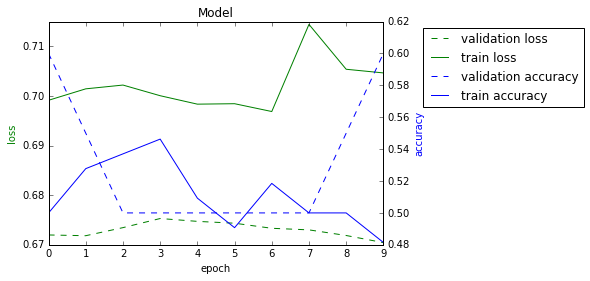

In [56]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions

In [57]:
datasize = X_val.shape[0]
best_model.predict_proba(X_val[:datasize,:,:],batch_size=1)

20/20 [==============================] - 0s     


array([[ 0.23774205,  0.76225793],
       [ 0.42726123,  0.57273877],
       [ 0.47522774,  0.52477229],
       [ 0.56032449,  0.43967551],
       [ 0.50775969,  0.49224034],
       [ 0.53032905,  0.46967092],
       [ 0.42614368,  0.57385635],
       [ 0.41877791,  0.58122206],
       [ 0.42620271,  0.57379729],
       [ 0.48054847,  0.5194515 ],
       [ 0.51029307,  0.4897069 ],
       [ 0.49676874,  0.50323129],
       [ 0.48777968,  0.51222032],
       [ 0.4940789 ,  0.50592113],
       [ 0.51520902,  0.48479098],
       [ 0.49308991,  0.50691009],
       [ 0.48494986,  0.51505017],
       [ 0.50336915,  0.49663082],
       [ 0.47661355,  0.52338648],
       [ 0.50390798,  0.49609205]])

In [59]:
best_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_19 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_19[0][0]
____________________________________________________________________________________________________
convolution1d_48 (Convolution1D) (None, 1280, 52)      2236        batchnormalization_19[0][0]      
____________________________________________________________________________________________________
activation_84 (Activation)       (None, 1280, 52)      0           convolution1d_48[0][0]           
____________________________________________________________________________________________________
convolution1d_49 (Convolution1D) (None, 1280, 45)      7065        activation_84[0][0]              
___________________________________________________________________________________________

In [75]:
X_val.shape

(20, 1280, 14)

In [60]:
len(best_model.layers)

10

In [76]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model.layers[0].input, K.learning_phase()],
                                  [best_model.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]

In [77]:
layer_output.shape

(20, 1280, 14)

In [82]:
layer_output.mean(axis=(0,1))

array([ 0.01279549, -0.00897324, -0.04084716, -0.07526646,  0.01399508,
       -0.06247653, -0.01134645,  0.00290158,  0.02717606, -0.04093175,
       -0.05238502,  0.05782415,  0.0397981 , -0.06900693], dtype=float32)

In [80]:
layer = best_model.layers[0]
for w in layer.get_weights():
    print(w.shape)

(14,)
(14,)
(14,)
(14,)


In [74]:
layer

## See if we can overfit on a small train set

In [118]:
params = models[0][1]
print(params)
small_model = modelgen.generate_CNN_model(X_train.shape, num_classes, params['filters'], params['fc_hidden_nodes'],
                                  0.01, #params['learning_rate'], 
                                        regularization_rate=0)
small_model.summary()

{'learning_rate': 6.266192650778009e-06, 'fc_hidden_nodes': 67, 'regularization_rate': 0.000641226389722406, 'filters': array([53, 38, 68])}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_34 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_34[0][0]
____________________________________________________________________________________________________
convolution1d_76 (Convolution1D) (None, 1280, 53)      2279        batchnormalization_34[0][0]      
____________________________________________________________________________________________________
activation_142 (Activation)      (None, 1280, 53)      0           convolution1d_76[0][0]           
____________________________________________________________________________________________________
convolution1d_77 (Convolution1D) (None, 1280, 38)  

In [114]:
small_model.evaluate(X_val, y_val_binary)

20/20 [==============================] - 0s


[8.8649530410766602, 0.44999998807907104]

In [119]:
nr_epochs = 100
datasize = 20
history = small_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=10)

Train on 20 samples, validate on 20 samples
Epoch 1/100
20/20 [==============================] - 0s - loss: 1.1408 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 4/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 5/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 6/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 7/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 8/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.865

KeyboardInterrupt: 

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

In [ ]:
best_model.get_config()[0]